In [1]:
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.pipeline import _name_estimators
from sklearn.preprocessing import LabelEncoder
import six
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
import operator

import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection  import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ Классификатор, который построен на основе "голоса большинства"
    """
    
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        # Fit
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # применим кодирование элементов, чтобы было удобнее работать
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            # собрать все результаты clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            # расчет взвешенного результата
            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        # предикт вероятностей по классам из выборки 
        
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        # параметры для GridSearch
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

In [5]:
class FWLS_Classifier():
    """
        FWLS ансамбль для классификации использует LogReg

    """
    def __init__(self, classifiers):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}

    def fit(self, x, y):
        # Fit classifiers
        
        # кодировка
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(x, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, x):
        # сбор всех результатов clf.predict calls
        predictions = np.asarray([clf.predict(x) for clf in self.classifiers_]).T
        return predictions

    def get_params(self, deep=True):
        # параметры для GridSearch
        if not deep:
            return super(FWLS_Classifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return 

#### Рассмотрим пример

In [6]:
# загрузка данных (просто классификатор, не рекомендатор)
iris = datasets.load_iris() 
x = iris.data[:]
y = iris.target[:]
y = LabelEncoder().fit_transform(y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=1)

#### Создадим набор пайплайнов

In [7]:
#SVM pipeline
pipe_svc = Pipeline([('scl', StandardScaler()), ('clf', SVC(random_state=1, probability=True))])


# параметры для тюнинга
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'clf__C': param_range, 'clf__kernel': ['linear']},
                 {'clf__C': param_range, 'clf__gamma': param_range, 'clf__kernel': ['rbf']}]

# лучшие парамтеры
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=5)
gs.fit(x_train, y_train)
best_SVM_params = gs.best_params_
print("Optimal SVM parameters are: ", best_SVM_params)
scores = cross_val_score(gs, x_train, y_train, scoring='accuracy', cv=5)
print("Average SVM Accuracy: %.3f +/- %.3f" % (np.mean(scores), np.std(scores)))


# отбор первого классификатора
classifier1 = SVC(C=gs.best_params_['clf__C'], kernel=gs.best_params_['clf__kernel'], gamma=gs.best_params_['clf__gamma'])

Optimal SVM parameters are:  {'clf__C': 100.0, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}
Average SVM Accuracy: 0.956 +/- 0.042


In [8]:
#Random forest pipeline
pipe_rf = Pipeline([('clf', RandomForestClassifier(criterion='entropy', random_state=1, n_jobs=-1))])

# параметры для тюнинга
param_range_trees = [10, 50, 100, 200, 500]
param_range_features = [2, 3, 4]
param_grid = [{'clf__n_estimators': param_range_trees, 'clf__max_features': param_range_features}]


# поиск лучших
gs = GridSearchCV(estimator=pipe_rf, param_grid=param_grid, scoring='accuracy', cv=5)
gs.fit(x_train, y_train)
best_rf_params = gs.best_params_
print("Optimal RF parameters are: ", best_rf_params)
scores = cross_val_score(gs, x_train, y_train, scoring='accuracy', cv=2)
print("Average RF Accuracy: %.3f +/- %.3f" % (np.mean(scores), np.std(scores)))

#второй классификатор
classifier2 = RandomForestClassifier(n_estimators=gs.best_params_['clf__n_estimators'], max_features=gs.best_params_['clf__max_features'], criterion='entropy', random_state=1, n_jobs=-1)

Optimal RF parameters are:  {'clf__max_features': 2, 'clf__n_estimators': 100}
Average RF Accuracy: 0.933 +/- 0.022


In [9]:
#KNN pipeline
pipe_knn = Pipeline([('scl', StandardScaler()), ('clf', KNeighborsClassifier())])


# параметры для тюнинга
param_range = [1, 2, 5, 9]
param_grid = [{'clf__n_neighbors': param_range}]
gs = GridSearchCV(estimator=pipe_knn, param_grid=param_grid, scoring='accuracy', cv=5)
gs.fit(x_train, y_train)
best_KNN_params = gs.best_params_
print("Optimal KNN parameters are: ", best_KNN_params)
scores = cross_val_score(gs, x_train, y_train, scoring='accuracy', cv=5)
print("Average KNN Accuracy: %.3f +/- %.3f" % (np.mean(scores), np.std(scores)))




# третий классификатор
classifier3 = KNeighborsClassifier(n_neighbors=gs.best_params_['clf__n_neighbors'])

Optimal KNN parameters are:  {'clf__n_neighbors': 1}
Average KNN Accuracy: 0.922 +/- 0.057


### Создаем единый классификтор - Majority vote ensemble

In [13]:
# объединяем пайпланый и добавляем скалирование
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', classifier1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', classifier3]])

# метки моделей
clf_labels = ['SVM', 'Random Forest', 'KNN', 'Majority Vote Classifier']


# инит основной модели
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, classifier2, pipe3])

In [14]:
# 10 фолдов для кросс-валидации
all_clf = [pipe1, classifier2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=x_train, y=y_train, scoring='accuracy', cv=10)
    print("Average accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

#Fit
mv_clf.fit(x_train, y_train)
#Предикт
y_test_pred = mv_clf.predict(x_test)


Average accuracy: 0.98 (+/- 0.04) [SVM]
Average accuracy: 0.93 (+/- 0.07) [Random Forest]
Average accuracy: 0.93 (+/- 0.07) [KNN]
Average accuracy: 0.94 (+/- 0.06) [Majority Vote Classifier]


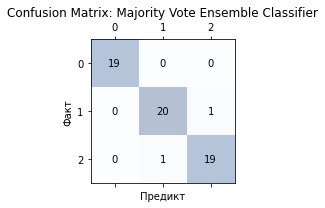

In [15]:
# Обзор результатов
confmat = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i,j], va='center', ha='center')
plt.xlabel('Предикт')
plt.ylabel('Факт')
plt.title('Confusion Matrix: Majority Vote Ensemble Classifier')
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.show()



### Создаем единый классификтор - FWLS

In [16]:
# создаем пайплайны
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', classifier1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', classifier3]])

# инит модели
fwls_clf = FWLS_Classifier(classifiers=[pipe1, classifier2, pipe3])

#Fit
fwls_clf.fit(x_train, y_train)
#предикт трейн
y_train_pred = fwls_clf.predict(x_train)
#предикт тест
y_test_pred = fwls_clf.predict(x_test)


In [17]:
# обучим регрессию для синка результатов
pipe_lr = Pipeline([('clf', LogisticRegression(random_state=1))])
pipe_lr.fit(y_train_pred, y_train)
#предикт FWLS
y_pred = pipe_lr.predict(y_test_pred)
             
print('Test Accuracy of FWLS ensemble model: %.3f' % pipe_lr.score(y_test_pred, y_test))

Test Accuracy of FWLS ensemble model: 0.967


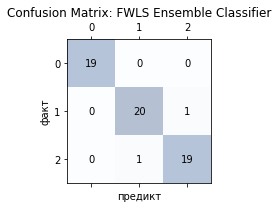

In [18]:
# Обзор результатов
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i,j], va='center', ha='center')
plt.xlabel('предикт')
plt.ylabel('факт')
plt.title('Confusion Matrix: FWLS Ensemble Classifier')
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.show()